In [2]:
# Importing necessary libraries
import os
import pandas as pd
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Downloading required NLTK resources (only need to do once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define the folder path where the text files are stored
folder_path = '/home/bhagyaperamuna/Desktop/SLIIT/ML/Assigment/articles'   # Replace with your folder path

# Step 1: Read all text files from the folder and store their content in a list
files = os.listdir(folder_path)
texts = []

# Loop through all files in the folder and read their contents
for file in files:
    if file.endswith('.txt'):  # Ensure you're reading only .txt files
        file_path = os.path.join(folder_path, file)
        with open(file_path, 'r', encoding='utf-8') as f:
            texts.append(f.read())

# Step 2: Create a DataFrame from the text files
df = pd.DataFrame(texts, columns=['Review'])
df['File Name'] = files  # Add the file name as an additional column, if needed

# Step 3: Cleaning the text (removing special characters, punctuation, etc.)
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove URLs, numbers, and special characters
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove anything that's not a letter or whitespace

    return text

# Apply the cleaning function to the 'Review' column
df['cleaned_review'] = df['Review'].apply(clean_text)

# Step 4: Tokenization
def tokenize_text(text):
    return word_tokenize(text)

# Tokenize the cleaned text
df['tokenized_review'] = df['cleaned_review'].apply(tokenize_text)

# Step 5: Removing stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Remove stopwords from the tokenized reviews
df['cleaned_tokens'] = df['tokenized_review'].apply(remove_stopwords)

# Step 6: Lemmatization (reducing words to their base form)
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization to the tokenized reviews
df['lemmatized_tokens'] = df['cleaned_tokens'].apply(lemmatize_tokens)

# Step 7: Convert the cleaned and lemmatized tokens back to text
def tokens_to_text(tokens):
    return ' '.join(tokens)

# Join tokens back into a single string for each review
df['final_review'] = df['lemmatized_tokens'].apply(tokens_to_text)

# Step 8: Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to top 5000 words
X = vectorizer.fit_transform(df['final_review'])

# Display the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", X.shape)

# Optional: Display a sample of the vectorized features (first 10)
print("Feature names (first 10):", vectorizer.get_feature_names_out()[:10])

# Now the data is preprocessed and ready for DBSCAN or any other clustering algorithm


[nltk_data] Downloading package punkt to
[nltk_data]     /home/bhagyaperamuna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bhagyaperamuna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/bhagyaperamuna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Shape of TF-IDF matrix: (2806, 5000)
Feature names (first 10): ['aaplo' 'aaron' 'ab' 'abandoned' 'ability' 'able' 'abramowitz' 'abroad'
 'absence' 'absolutely']


Number of clusters (excluding noise): 12
Noise points (label -1): 2740
Silhouette Score: -0.24839201049288395


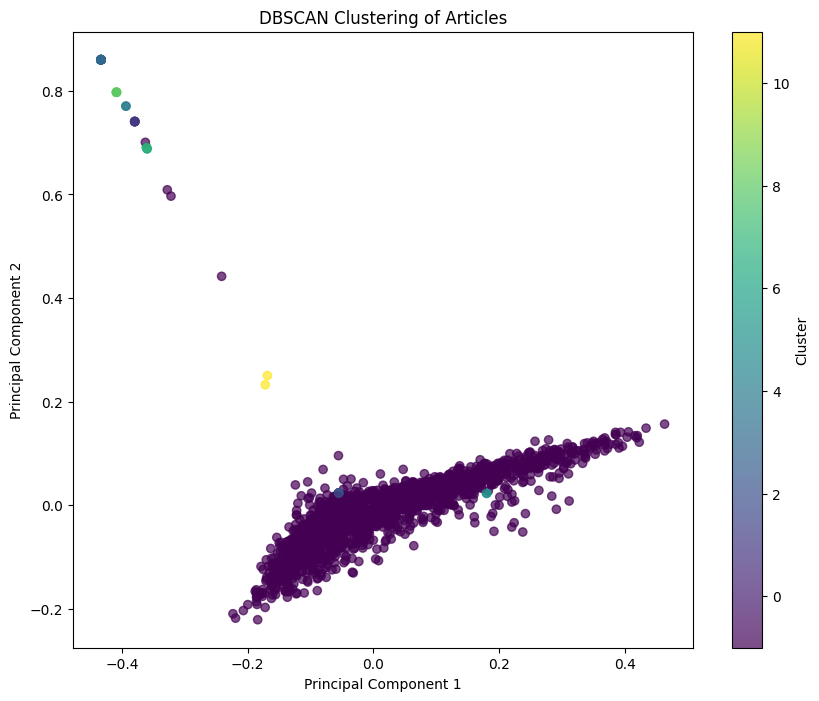

In [4]:
# Import necessary libraries
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Step 1: Apply DBSCAN clustering
# Initialize DBSCAN model (tune eps and min_samples based on your dataset)
dbscan = DBSCAN(eps=0.3, min_samples=2)  # Adjust eps and min_samples for better results
dbscan_labels = dbscan.fit_predict(X)  # X is the TF-IDF matrix from preprocessing

# Add the DBSCAN cluster labels to the DataFrame
df['DBSCAN_Cluster'] = dbscan_labels

# Step 2: Analyze the results
# Count the number of clusters and noise points
unique_labels = set(dbscan_labels)
print(f"Number of clusters (excluding noise): {len(unique_labels) - (1 if -1 in unique_labels else 0)}")
print(f"Noise points (label -1): {list(dbscan_labels).count(-1)}")

# Step 3: Evaluate DBSCAN using silhouette score
if len(unique_labels) > 1 and -1 in unique_labels:
    silhouette_avg = silhouette_score(X, dbscan_labels)
    print(f"Silhouette Score: {silhouette_avg}")

# Step 4: Visualize DBSCAN Clusters in 2D using PCA (Dimensionality reduction)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())

# Plot DBSCAN Clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels, cmap='viridis', marker='o', alpha=0.7)
plt.title("DBSCAN Clustering of Articles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()
